## Code

In [165]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import random

import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Recall

### Read data from .csv and prepare it for training

In [ ]:
# Data variables
TEST_SIZE = 0.3  # percentage split of training and test data
RANDOM_STATE = 666  # random state for reproducible results
INPUT_SIZE = (28, 28, 3)  # shape of the input images
NUM_CLASSES = 7  # number of multi-class labels

In [ ]:
# Read image data from csv file into a DataFrame
# TODO: this should read from the SQLite DB instead
image_data_df = pd.read_csv("hmnist_28_28_RGB.csv", sep=",")

# Convert dataFrame to numpy array with float values
image_data = np.array(image_data_df, dtype="float32")

# Split the data into pixel values and target labels
# Normalize the pixel data by dividing by the range (255)
# NOTE: decide if normalization should instead be part of the ML pipline pre-processing
X = image_data[:, :-1] / 255  # all columns except the last one
y = image_data[:, -1]  # only the last column (label)

In [ ]:
# Split image data into training, validation, and testing datasets
# We use a stratified split on the y-label in order to ensure a balanced distribution of labels across all subsets
# https://en.wikipedia.org/wiki/Stratified_sampling
# https://stackoverflow.com/questions/61885259/using-sklearn-train-test-split-for-imbalanced-data
# https://scikit-learn.org/stable/modules/cross_validation.html#stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, stratify=y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

# NOTE: this code assumes an even split between evaluation and test data
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, stratify=y_val, test_size=0.5, random_state=RANDOM_STATE
)

In [ ]:
# Verify the shapes of the resulting datasets
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")

X_train: (7010, 2352), y_train: (7010,)
X_val:   (1502, 2352), y_val:   (1502,)
X_test:  (1503, 2352), y_test:  (1503,)


In [ ]:
# Reshape the data into the form that the CNN accepts
# NOTE: we use * notation to unpack the second argument that is a tuple
X_train = X_train.reshape(X_train.shape[0], *INPUT_SIZE)
X_val = X_val.reshape(X_val.shape[0], *INPUT_SIZE)
X_test = X_test.reshape(X_test.shape[0], *INPUT_SIZE)

In [113]:
# Check the reshaped datasets
print(f"X_train: {X_train.shape}")
print(f"X_val:   {X_val.shape}")
print(f"X_test:  {X_test.shape}")

X_train: (7010, 28, 28, 3)
X_val:   (1502, 28, 28, 3)
X_test:  (1503, 28, 28, 3)


In [ ]:
# Convert integer target labels to categorical format for better model performance
y_train_cat = to_categorical(y_train, num_classes=NUM_CLASSES)
y_val_cat = to_categorical(y_val, num_classes=NUM_CLASSES)
y_test_cat = to_categorical(y_test, num_classes=NUM_CLASSES)

#### Optional: check out the gore

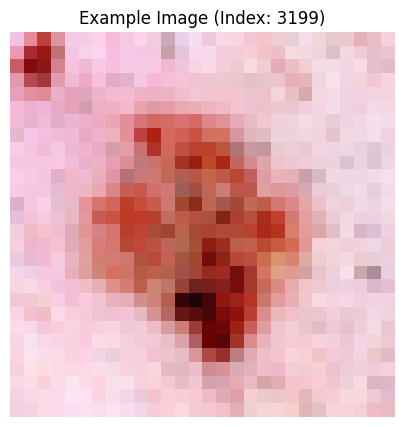

In [ ]:
# Choose a random index
index = random.randint(0, len(X_train) - 1)

# Extract the image
image = X_train[index]

# Plot the image
plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.title(f"Example Image (Index: {index})")
plt.show()

### CNN Model (training)

In [ ]:
# Model variables
NUM_FILTERS = 20
FILTER_SIZE = (3, 3)  # tuple since the input images have 3 layers (RGB)

POOL_SIZE = 2
STRIDE = 1

DROPOUT_RATE = 0

OUTPUT_DIM = 7

CONV_ACTIVATION = "relu"
DENSE_ACTIVATION = "softmax"

OPTIMIZER = "adam"  # we can replace this with tf.keras.optimizers.Adam() to modify parameters such as learning rate
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
LOSS_FUNCTION = "categorical_crossentropy"  # Used for multi-class classification with categorical target labels (one-hot)

NUM_EPOCHS = 5
BATCH_SIZE = 1

In [ ]:
# Create the CNN model
model = Sequential(
    [
        Input(INPUT_SIZE),
        Conv2D(NUM_FILTERS, FILTER_SIZE, activation=CONV_ACTIVATION),
        MaxPooling2D(POOL_SIZE, STRIDE),
        Dropout(DROPOUT_RATE),
        Flatten(),
        Dense(OUTPUT_DIM, DENSE_ACTIVATION),
    ]
)

model.compile(
    OPTIMIZER,
    loss=LOSS_FUNCTION,
    metrics=["accuracy", "recall"],  # include monitoring of recall rate
)

# NOTE: we are using the categorical target matrices here
model.fit(
    X_train,
    y_train_cat,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val_cat),
)

Epoch 1/5
7010/7010 ━━━━━━━━━━━━━━━━━━━━ 74s 10ms/step - accuracy: 0.6652 - loss: 1.0696 - recall: 0.5216 - val_accuracy: 0.6671 - val_loss: 0.9457 - val_recall: 0.5919
Epoch 2/5
7010/7010 ━━━━━━━━━━━━━━━━━━━━ 66s 9ms/step - accuracy: 0.6775 - loss: 0.9069 - recall: 0.5667 - val_accuracy: 0.6831 - val_loss: 0.8750 - val_recall: 0.5679
Epoch 3/5
7010/7010 ━━━━━━━━━━━━━━━━━━━━ 77s 11ms/step - accuracy: 0.6851 - loss: 0.8701 - recall: 0.5815 - val_accuracy: 0.6625 - val_loss: 0.9867 - val_recall: 0.4734
Epoch 4/5
7010/7010 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - accuracy: 0.6874 - loss: 0.8522 - recall: 0.5833 - val_accuracy: 0.6651 - val_loss: 0.8961 - val_recall: 0.5879
Epoch 5/5
7010/7010 ━━━━━━━━━━━━━━━━━━━━ 78s 11ms/step - accuracy: 0.7023 - loss: 0.8129 - recall: 0.6106 - val_accuracy: 0.6718 - val_loss: 0.9003 - val_recall: 0.5799


### Model evaluation

In [ ]:
# Make prediction on testing data
y_predicted = model.predict(X_test)

# Extract the predicted classes
# "In a two-dimensional vector, the elements of axis 0 are rows and the elements of axis 1 are columns."
# https://numpy.org/doc/2.1/glossary.html#term-axis
predicted_classes = np.argmax(y_predicted, axis=1)

# Evaluate model performance
test_loss, test_accuracy, test_recall = model.evaluate(X_test, y_test_cat)

print(f"Loss: {test_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Recall: {test_recall}")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.6712 - loss: 0.9047 - recall: 0.5667
Loss: 0.8749653100967407
Accuracy: 0.6859614253044128
Recall: 0.5768463015556335


In [158]:
# Generate target class names
target_names = ["Class {}".format(i) for i in range(NUM_CLASSES)]

# Print classification report
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.10      0.02      0.03        49
     Class 1       0.44      0.18      0.26        77
     Class 2       0.36      0.16      0.23       165
     Class 3       0.00      0.00      0.00        17
     Class 4       0.73      0.94      0.82      1006
     Class 5       0.62      0.23      0.33        22
     Class 6       0.45      0.26      0.33       167

    accuracy                           0.69      1503
   macro avg       0.39      0.26      0.29      1503
weighted avg       0.62      0.69      0.63      1503



/mnt/c/Users/Erik/Documents/University/Year-3/DIT826-SE-for-AI-Applications/group6/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/Erik/Documents/University/Year-3/DIT826-SE-for-AI-Applications/group6/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mnt/c/Users/Erik/Documents/University/Year-3/DIT826-SE-for-AI-Applications/group6/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and b

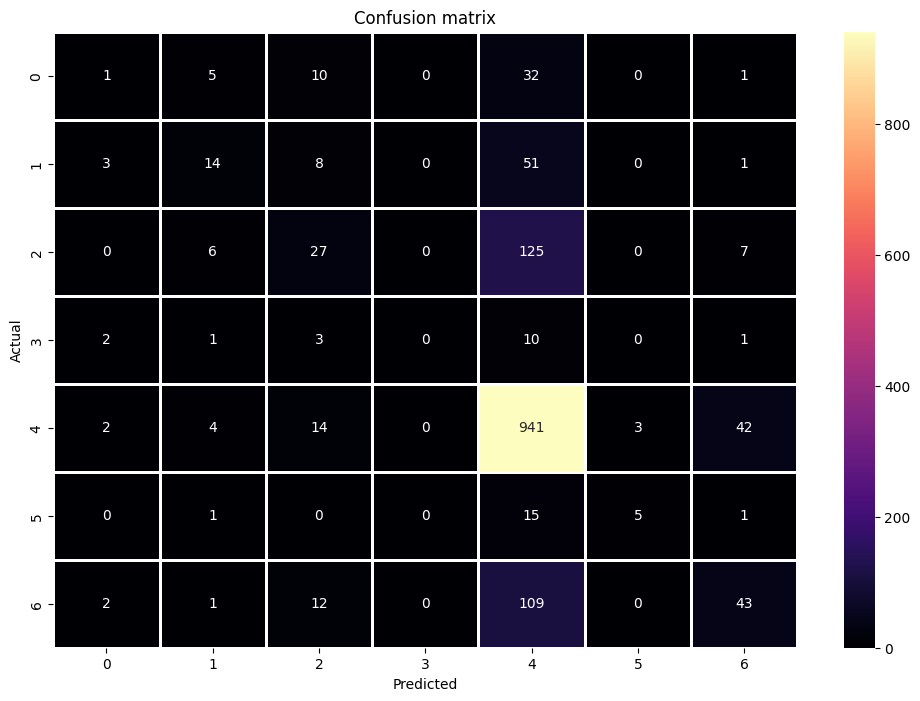

In [168]:
# Create new plot via pyplot
plt.figure(figsize=(12, 8))

cm = confusion_matrix(y_test, predicted_classes)
# Create the confusion matrix using seaborn heatmap function
sns.heatmap(cm, annot=True, cmap='magma', cbar=True, linewidths=1, fmt="d")

# Set labels for x and y axis
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix')

# Display
plt.show()

In [167]:
# Sum the diagonal element to get the total true correct values
ones = np.identity(cm.shape[0]) # Create an identity matrix to create a mask for the diagonal elements
sumOfDiagonalElements = np.sum(cm * ones) # Mask the diagonal elements, and sum the diagonals
print(sumOfDiagonalElements)

1031.0


### Save entire model to file


In [ ]:
# Save the entire model, including architecture, weights, and training configuration to file
# https://www.tensorflow.org/tutorials/keras/save_and_load#save_the_entire_model

# NOTE: WARNING this current placeholder implementation simply overwrites the model
# TODO: actual implementation should probably save the model temporarily to disk before writing to SQLite DB

# Construct file path from current directory
model_file_path = os.path.join(os.getcwd(), "model.keras")

# Save entire model to disk in the .keras format
model.save(model_file_path)

# Print model summary (because the table looks nice)
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 26, 26, 20)     │           560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 25, 25, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25, 25, 20)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │        87,507 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 264,203 (1.01 MB)

 Trainable params: 88,067 (344.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 176,136 (688.04 KB)